In [1]:
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, DateType, FloatType

In [3]:
from pyspark.sql.functions import col,sum, count, avg, round as F_round, countDistinct, least, greatest, when, concat_ws, \
    array, explode, collect_list, dense_rank

In [4]:
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql import Window

In [6]:
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("ipl_2024_data_analysis")
    .getOrCreate()
)

25/03/01 23:09:39 WARN Utils: Your hostname, dev resolves to a loopback address: 127.0.1.1; using 192.168.250.87 instead (on interface wlp1s0)
25/03/01 23:09:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/01 23:09:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark

In [8]:
# file paths

ball_by_ball_path = "hdfs://localhost:9000/data/ipl_2024/ball_by_ball.csv"
matches_path = "hdfs://localhost:9000/data/ipl_2024/matches.csv"

In [9]:
# Ball by Ball Schema

ball_by_ball_schema = StructType([
    StructField("match_id", StringType(), True),
    StructField("season", IntegerType(), True),
    StructField("match_no", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("venue", StringType(), True),
    StructField("batting_team", StringType(), True),
    StructField("bowling_team", StringType(), True),
    StructField("innings", IntegerType(), True),
    StructField("over", FloatType(), True),
    StructField("striker", StringType(), True),
    StructField("non_striker", StringType(), True),
    StructField("bowler", StringType(), True),
    StructField("runs_of_bat", IntegerType(), True),
    StructField("extras", IntegerType(), True),
    StructField("wide", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("wicket_type", StringType(), True),
    StructField("player_dismissed", StringType(), True),
    StructField("fielder", StringType(), True)
])

In [10]:
# Create ball_by_ball dataframe

ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header", "true").load(ball_by_ball_path)

In [12]:
ball_by_ball_df.show(1,truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------
 match_id         | 202401                                            
 season           | 2024                                              
 match_no         | 1                                                 
 date             | 2024-03-22                                        
 venue            | MA Chidambaram Stadium, Chepauk, Chennai, Chennai 
 batting_team     | RCB                                               
 bowling_team     | CSK                                               
 innings          | 1                                                 
 over             | 0.1                                               
 striker          | V Kohli                                           
 non_striker      | F du Plessis                                      
 bowler           | DL Chahar                                         
 runs_of_bat      | 0                                                 
 extra

In [13]:
ball_by_ball_df.printSchema()

root
 |-- match_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- match_no: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- venue: string (nullable = true)
 |-- batting_team: string (nullable = true)
 |-- bowling_team: string (nullable = true)
 |-- innings: integer (nullable = true)
 |-- over: float (nullable = true)
 |-- striker: string (nullable = true)
 |-- non_striker: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- runs_of_bat: integer (nullable = true)
 |-- extras: integer (nullable = true)
 |-- wide: integer (nullable = true)
 |-- legbyes: integer (nullable = true)
 |-- byes: integer (nullable = true)
 |-- noballs: integer (nullable = true)
 |-- wicket_type: string (nullable = true)
 |-- player_dismissed: string (nullable = true)
 |-- fielder: string (nullable = true)



In [14]:
ball_by_ball_df = ball_by_ball_df.withColumn("total_runs", col("runs_of_bat") + col("extras"))
ball_by_ball_df.show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------
 match_id         | 202401                                            
 season           | 2024                                              
 match_no         | 1                                                 
 date             | 2024-03-22                                        
 venue            | MA Chidambaram Stadium, Chepauk, Chennai, Chennai 
 batting_team     | RCB                                               
 bowling_team     | CSK                                               
 innings          | 1                                                 
 over             | 0.1                                               
 striker          | V Kohli                                           
 non_striker      | F du Plessis                                      
 bowler           | DL Chahar                                         
 runs_of_bat      | 0                                                 
 extra

In [15]:
# Matches Schema

match_schema = StructType([
    StructField("match_id", StringType(), True),
    StructField("season", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("match_no", IntegerType(), True),
    StructField("venue", StringType(), True),
    StructField("city", StringType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("toss_decision", StringType(), True),
    StructField("innings1_score", StringType(), True),
    StructField("innings1_wickets", StringType(), True),
    StructField("innings2_score", StringType(), True),
    StructField("innings2_wickets", StringType(), True),
    StructField("winning_team", StringType(), True),
    StructField("margin", StringType(), True),
    StructField("won_by", StringType(), True),
    StructField("player_of_the_match", StringType(), True),
    StructField("team1_players", StringType(), True),
    StructField("team2_players", StringType(), True),
    StructField("umpire1", StringType(), True),
    StructField("umpire2", StringType(), True),
    StructField("umpire3", StringType(), True)
])

In [16]:
match_df = spark.read.schema(match_schema).format("csv").option("header", "true").load(matches_path)

In [17]:
match_df.show(1,truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------
 match_id            | 202401                                                                                                                                              
 season              | 2024                                                                                                                                                
 date                | 2024-03-22                                                                                                                                          
 match_no            | 1                                                                                                                                                   
 venue               | MA Chidambaram Stadium, Chepauk, Chennai                                                                             

In [18]:
match_df.printSchema()

root
 |-- match_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- match_no: integer (nullable = true)
 |-- venue: string (nullable = true)
 |-- city: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- innings1_score: string (nullable = true)
 |-- innings1_wickets: string (nullable = true)
 |-- innings2_score: string (nullable = true)
 |-- innings2_wickets: string (nullable = true)
 |-- winning_team: string (nullable = true)
 |-- margin: string (nullable = true)
 |-- won_by: string (nullable = true)
 |-- player_of_the_match: string (nullable = true)
 |-- team1_players: string (nullable = true)
 |-- team2_players: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)
 |-- umpire3: string (nullable = true)



In [19]:
# Total number of matches played in 2024

total_matches = match_df.count()
total_matches

74

In [20]:
# List all unique venues where matches were played.

venue_df = match_df.select(col("venue")).distinct()
venue_df.show(truncate=False)

+---------------------------------------------------------------------+
|venue                                                                |
+---------------------------------------------------------------------+
|M Chinnaswamy Stadium, Bengaluru                                     |
|Rajiv Gandhi International Stadium, Hyderabad                        |
|Arun Jaitley Stadium, Delhi                                          |
|Sawai Mansingh Stadium, Jaipur                                       |
|Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow|
|Wankhede Stadium, Mumbai                                             |
|Himachal Pradesh Cricket Association Stadium, Dharamsala             |
|Rajiv Gandhi International Stadium, Uppal, Hyderabad                 |
|Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam   |
|Narendra Modi Stadium, Ahmedabad                                     |
|MA Chidambaram Stadium, Chepauk, Chennai                       

+------------+-----+
|winning_team|count|
+------------+-----+
|         KKR|   11|
|          DC|    7|
|          RR|    9|
|         LSG|    7|
|          MI|    4|
|          GT|    5|
|         CSK|    7|
|         SRH|    9|
|         RCB|    7|
|        PBKS|    5|
+------------+-----+



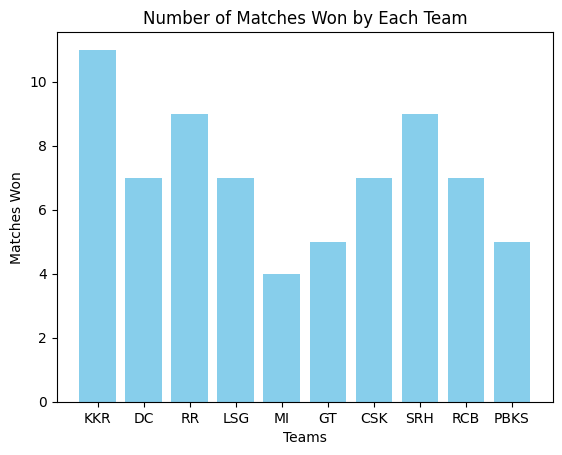

In [21]:
# Find the number of matches won by each team.

no_of_match_won_df = (
    match_df.select(col("winning_team"))
    .filter(col("winning_team").isNotNull())
    .groupBy("winning_team").count()
)
no_of_match_won_df.show()

no_of_match_won_df= no_of_match_won_df.toPandas()

x = no_of_match_won_df["winning_team"]
y = no_of_match_won_df["count"]

plt.bar(x, y, color="skyblue")
plt.xlabel("Teams")
plt.ylabel("Matches Won")
plt.title("Number of Matches Won by Each Team")
plt.show()

In [22]:
# Find the number of matches with no result

matches_with_no_res_df = (
    match_df.select(col("match_no"), col("date"), col("venue"), col("team1"), col("team2"))
    .filter(col("winning_team").isNull())
)
matches_with_no_res_df.show(truncate=False)

+--------+----------+---------------------------------------------+-----+-----+
|match_no|date      |venue                                        |team1|team2|
+--------+----------+---------------------------------------------+-----+-----+
|63      |2024-05-13|Narendra Modi Stadium, Ahmedabad             |GT   |KKR  |
|66      |2024-05-16|Rajiv Gandhi International Stadium, Hyderabad|SRH  |GT   |
|70      |2024-05-19|Barsapara Cricket Stadium, Guwahati          |RR   |KKR  |
+--------+----------+---------------------------------------------+-----+-----+



+----+----------+
|team|total_runs|
+----+----------+
| SRH|      3052|
| RCB|      2930|
| KKR|      2667|
|  RR|      2647|
|  DC|      2573|
|  MI|      2568|
| CSK|      2524|
|PBKS|      2487|
| LSG|      2483|
|  GT|      2040|
+----+----------+



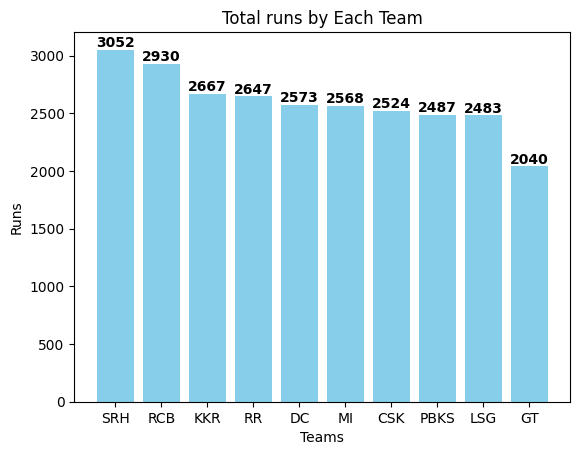

In [23]:
# Find the total runs scored by each team in IPL 2024.

total_runs_by_team_df = (
    ball_by_ball_df.groupBy("batting_team")
        .agg(sum("total_runs").alias("total_runs")).orderBy(col("total_runs").desc())
        .select(col("batting_team").alias("team"), col("total_runs"))
)
total_runs_by_team_df.show()

total_runs_by_team_df = total_runs_by_team_df.toPandas()

x = total_runs_by_team_df["team"]
y = total_runs_by_team_df["total_runs"]

bars = plt.bar(x, y, color="skyblue")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),  
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
plt.xlabel("Teams")
plt.ylabel("Runs")
plt.title("Total runs by Each Team")
plt.show()

In [24]:
# Identify the player with the most runs in the season. (Orange cap holder)

most_run_by_individual_df = (
    ball_by_ball_df.groupBy("striker")
    .agg(sum("runs_of_bat").alias("total_runs"))
    .select(col("striker").alias("player"), col("total_runs"))
)

orange_cap_df = (
    ball_by_ball_df.select(col("striker").alias("player"), col("batting_team").alias("team")).distinct()
    .join(most_run_by_individual_df, "player", "inner")
    .select(col("player"), col("team"), col("total_runs"))
    .orderBy(col("total_runs").desc())
)
orange_cap_df.show(1)

+-------+----+----------+
| player|team|total_runs|
+-------+----+----------+
|V Kohli| RCB|       741|
+-------+----+----------+
only showing top 1 row



In [25]:
# Top 10 highest runs scorers

orange_cap_df.show(10)

+---------------+----+----------+
|         player|team|total_runs|
+---------------+----+----------+
|        V Kohli| RCB|       741|
|     RD Gaikwad| CSK|       583|
|        R Parag|  RR|       573|
|        TM Head| SRH|       567|
|      SV Samson|  RR|       531|
|B Sai Sudharsan|  GT|       527|
|       KL Rahul| LSG|       520|
|       N Pooran| LSG|       499|
|      SP Narine| KKR|       488|
|Abhishek Sharma| SRH|       484|
+---------------+----+----------+
only showing top 10 rows



In [26]:
# Calculate the total wickets taken by each bowler. (Purple cap holder)

total_wickets_by_individual_df = (
    ball_by_ball_df.filter(col("wicket_type").isin(["caught", "lbw", "stumped", "bowled"]))
    .groupBy("bowler").count()
    .select(col("bowler").alias("player"), col("count").alias("total_wickets"))
)

purple_cap_df = (
    ball_by_ball_df.select(col("bowler").alias("player"), col("bowling_team").alias("team")).distinct()
    .join(total_wickets_by_individual_df, "player", "inner")
    .select(col("player"), col("team"), col("total_wickets"))
    .orderBy(col("total_wickets").desc())
)

purple_cap_df.show(1)

+--------+----+-------------+
|  player|team|total_wickets|
+--------+----+-------------+
|HV Patel|PBKS|           24|
+--------+----+-------------+
only showing top 1 row



In [27]:
# Top 10 wickets taken bowler

purple_cap_df.show(10)

+--------------+----+-------------+
|        player|team|total_wickets|
+--------------+----+-------------+
|      HV Patel|PBKS|           24|
|      CV Varun| KKR|           21|
|     JJ Bumrah|  MI|           20|
|  Harshit Rana| KKR|           19|
|    Avesh Khan|  RR|           19|
|    AD Russell| KKR|           19|
|   T Natarajan| SRH|           19|
|Arshdeep Singh|PBKS|           19|
|     YS Chahal|  RR|           18|
|    PJ Cummins| SRH|           18|
+--------------+----+-------------+
only showing top 10 rows



In [28]:
# Batsman with more 4's

highest_four_df = (
    ball_by_ball_df.filter((col("runs_of_bat") == 4))
    .groupBy("striker").agg(count("striker").alias("total_fours"))
    .orderBy(col("total_fours").desc())
)
highest_four_df.show()

+---------------+-----------+
|        striker|total_fours|
+---------------+-----------+
|        TM Head|         64|
|        V Kohli|         62|
|     RD Gaikwad|         58|
|    YBK Jaiswal|         54|
|        PD Salt|         50|
|      SP Narine|         50|
|      SV Samson|         48|
|B Sai Sudharsan|         48|
|   F du Plessis|         47|
|      RG Sharma|         45|
|       KL Rahul|         45|
|        R Parag|         40|
|     MP Stoinis|         39|
|   Shubman Gill|         37|
|       SA Yadav|         36|
|        RR Pant|         36|
|     JC Buttler|         36|
|  Abishek Porel|         36|
|Abhishek Sharma|         36|
|       N Pooran|         35|
+---------------+-----------+
only showing top 20 rows



In [29]:
# Batsman with more 6's

highest_six_df = (
    ball_by_ball_df.filter((col("runs_of_bat") == 6))
    .groupBy("striker").agg(count("striker").alias("total_sixes"))
    .orderBy(col("total_sixes").desc())
)

highest_six_df.show()

+-------------------+-----------+
|            striker|total_sixes|
+-------------------+-----------+
|    Abhishek Sharma|         42|
|          H Klaasen|         38|
|            V Kohli|         38|
|           N Pooran|         36|
|          SP Narine|         33|
|            R Parag|         33|
|         RM Patidar|         33|
|            TM Head|         32|
|             S Dube|         28|
|    J Fraser-McGurk|         28|
|           T Stubbs|         26|
|            RR Pant|         25|
|          SV Samson|         24|
|            PD Salt|         24|
|          RG Sharma|         23|
|         KD Karthik|         22|
|Nithish Kumar Reddy|         21|
|       F du Plessis|         21|
|     Shashank Singh|         21|
|     P Simran Singh|         20|
+-------------------+-----------+
only showing top 20 rows



In [30]:
# Find the batsman with the most sixes and fours.

highest_six_four_df = (
    ball_by_ball_df.filter((col("runs_of_bat") == 4) | (col("runs_of_bat") == 6))
    .groupBy("striker").agg(count("striker").alias("total_count"))
    .orderBy(col("total_count").desc())
)

highest_six_four_df.show()

+---------------+-----------+
|        striker|total_count|
+---------------+-----------+
|        V Kohli|        100|
|        TM Head|         96|
|      SP Narine|         83|
|Abhishek Sharma|         78|
|     RD Gaikwad|         76|
|        PD Salt|         74|
|        R Parag|         73|
|      SV Samson|         72|
|       N Pooran|         71|
|    YBK Jaiswal|         70|
|      RG Sharma|         68|
|   F du Plessis|         68|
|B Sai Sudharsan|         65|
|       KL Rahul|         64|
|        RR Pant|         61|
|J Fraser-McGurk|         60|
|      H Klaasen|         57|
|         S Dube|         56|
|     MP Stoinis|         55|
|       SA Yadav|         54|
+---------------+-----------+
only showing top 20 rows



In [31]:
# Identify the bowler with the most dot balls.

dot_balls_df = (
    ball_by_ball_df.filter(col("total_runs") == 0)
    .groupBy("bowler")
    .agg(count("*").alias("dot_balls"))
)

total_balls_bowled_df = ball_by_ball_df.groupBy("bowler").agg(count("*").alias("total_balls_bowled"))

total_dot_balls_df = dot_balls_df.join(total_balls_bowled_df, "bowler", "inner").orderBy(col("dot_balls").desc())

total_dot_balls_df.show()

+--------------+---------+------------------+
|        bowler|dot_balls|total_balls_bowled|
+--------------+---------+------------------+
|     JJ Bumrah|      144|               328|
|      TA Boult|      132|               333|
|       B Kumar|      126|               357|
|    PJ Cummins|      123|               375|
|     SP Narine|      122|               334|
|Mohammed Siraj|      121|               350|
|      CV Varun|      121|               309|
|      KK Ahmed|      120|               324|
|    Yash Dayal|      116|               322|
|  TU Deshpande|      111|               310|
|   T Natarajan|      108|               332|
|Arshdeep Singh|      108|               326|
|      MA Starc|      102|               267|
|     YS Chahal|       98|               362|
|    Avesh Khan|       97|               346|
|  Harshit Rana|       93|               264|
|      K Rabada|       93|               262|
|  Ravi Bishnoi|       88|               270|
|      R Ashwin|       87|        

In [32]:
# Determine the best bowling figures (most wickets in a match).

most_wickets_df = (
    ball_by_ball_df.filter(col("wicket_type").isin(["caught", "lbw", "stumped", "bowled"]))
    .groupBy("bowler", "match_id")
    .agg(count("wicket_type").alias("wickets"))
)

runs_conceded_df = (
    ball_by_ball_df.groupBy("bowler", "match_id")
    .agg(sum("total_runs").alias("runs_conceded"))
)

unique_team_df = ball_by_ball_df.dropDuplicates(["match_id"]).select("match_id", "bowling_team", "batting_team")

most_wick_in_match_df = (
    most_wickets_df.join(runs_conceded_df, ["bowler", "match_id"], "inner")
    .join(unique_team_df, "match_id", "inner")
    .select(col("bowler"),
            col("bowling_team").alias("team"),
            col("batting_team").alias("against"),
            col("wickets"),
            col("runs_conceded"))
    .orderBy(col("wickets").desc())
)

most_wick_in_match_df.show()

+-----------------+----+-------+-------+-------------+
|           bowler|team|against|wickets|runs_conceded|
+-----------------+----+-------+-------+-------------+
|      Yash Thakur|  GT|    LSG|      5|           31|
|   Sandeep Sharma|  RR|     MI|      5|           18|
|        JJ Bumrah|  MI|    RCB|      5|           22|
|    Kuldeep Yadav|  DC|    SRH|      4|           55|
|Mustafizur Rahman| CSK|    RCB|      4|           30|
|      T Natarajan|  DC|    SRH|      4|           19|
|     TU Deshpande| SRH|    CSK|      4|           27|
|         MA Starc|  MI|    KKR|      4|           33|
|         J Little| RCB|     GT|      4|           45|
|        G Coetzee|  DC|     MI|      4|           35|
|    R Sai Kishore|  GT|   PBKS|      4|           33|
|      M Pathirana|  MI|    CSK|      4|           30|
|   Arshdeep Singh|PBKS|    SRH|      4|           29|
|     Rasikh Salam|  MI|     DC|      3|           35|
|        YS Chahal|  RR|     MI|      3|           11|
|         

In [33]:
# Find the highest individual score by a batsman in a match.

total_runs_df = (
    ball_by_ball_df.filter(col("wide") == 0)
    .groupBy("striker", "match_id", "innings")
    .agg(sum("runs_of_bat").alias("runs"), count("*").alias("balls_faced"))
    .orderBy(col("runs").desc())
)

unique_team_df = ball_by_ball_df.dropDuplicates(["match_id", "innings"]).select("match_id", "bowling_team", "batting_team", "innings")

highest_individual_runs_df = (
    total_runs_df.join(unique_team_df, ["match_id", "innings"], "inner")
    .select(col("striker").alias("player"),
            col("batting_team").alias("team"),
            col("bowling_team").alias("against"),
            col("runs"),
            col("balls_faced"))
    .orderBy(col("runs").desc())
)

highest_individual_runs_df.show()

+---------------+----+-------+----+-----------+
|         player|team|against|runs|balls_faced|
+---------------+----+-------+----+-----------+
|     MP Stoinis| LSG|    CSK| 124|         63|
|        V Kohli| RCB|     RR| 113|         72|
|      SP Narine| KKR|     RR| 109|         56|
|    JM Bairstow|PBKS|    KKR| 108|         48|
|     RD Gaikwad| CSK|    LSG| 108|         60|
|     JC Buttler|  RR|    KKR| 107|         60|
|      RG Sharma|  MI|    CSK| 105|         63|
|    YBK Jaiswal|  RR|     MI| 104|         60|
|   Shubman Gill|  GT|    CSK| 104|         55|
|B Sai Sudharsan|  GT|    CSK| 103|         51|
|        TM Head| SRH|    RCB| 102|         41|
|       SA Yadav|  MI|    SRH| 102|         51|
|     JC Buttler|  RR|    RCB| 100|         58|
|       WG Jacks| RCB|     GT| 100|         41|
|     RD Gaikwad| CSK|    SRH|  98|         54|
|        V Kohli| RCB|   PBKS|  92|         47|
|   Shubman Gill|  GT|   PBKS|  89|         48|
|        TM Head| SRH|    LSG|  89|     

In [34]:
# Calculate the team with the best average powerplay score (overs 1-6).

best_powerplay_df = (
    ball_by_ball_df.filter(col("over") <= 6)
    .groupBy("batting_team", "match_id")
    .agg(sum("runs_of_bat").alias("powerplay_runs"))
    .groupBy("batting_team")
    .agg(F_round(avg("powerplay_runs"), 2).alias("avg_powerplay_score"))
    .orderBy(col("avg_powerplay_score").desc())
)

best_powerplay_df.show()

+------------+-------------------+
|batting_team|avg_powerplay_score|
+------------+-------------------+
|         SRH|              63.94|
|         KKR|              60.64|
|          DC|              60.64|
|         RCB|              56.47|
|          MI|              51.79|
|        PBKS|              51.14|
|         CSK|              49.86|
|          RR|              49.33|
|         LSG|              47.14|
|          GT|              43.83|
+------------+-------------------+



+----------------+----------+--------------+
|player_dismissed|dismissals|matches_played|
+----------------+----------+--------------+
| Abhishek Sharma|        15|            15|
|    F du Plessis|        15|            15|
|         TM Head|        14|            14|
|       SP Narine|        14|            14|
|     YBK Jaiswal|        14|            14|
|        KL Rahul|        14|            14|
|  P Simran Singh|        14|            14|
|    Ishan Kishan|        14|            14|
|       RG Sharma|        13|            13|
|      RM Patidar|        13|            13|
+----------------+----------+--------------+



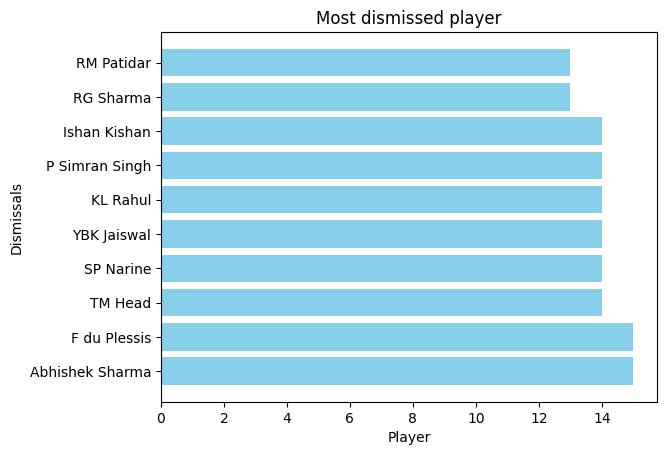

In [35]:
# Identify the player who has been dismissed the most.

most_dismissed_player_df = (
    ball_by_ball_df.filter(col("player_dismissed").isNotNull()) 
    .groupBy("player_dismissed")
    .agg(count("*").alias("dismissals"))
    .orderBy(col("dismissals").desc())
)

matches_played_df = (
    ball_by_ball_df.select("player_dismissed", "match_id")
    .filter(col("player_dismissed").isNotNull())
    .distinct()
    .groupBy("player_dismissed")
    .agg(count("match_id").alias("matches_played"))
)

final_df = most_dismissed_player_df.join(matches_played_df, "player_dismissed", "left")

final_df = final_df.orderBy(col("dismissals").desc()).limit(10)

final_df.show()

final_df= final_df.toPandas()

x = final_df["player_dismissed"]
y = final_df["dismissals"]

plt.barh(x, y, color="skyblue")
plt.xlabel("Player")
plt.ylabel("Dismissals")
plt.title("Most dismissed player")
plt.show()

In [37]:
# Number of matches played by each team

matches_played_df = (
    match_df.select("match_id", "team1")
    .withColumnRenamed("team1", "team")
    .union(match_df.select("match_id", col("team2").alias("team")))
    .groupBy("team")
    .agg(countDistinct("match_id").alias("matches_played"))
    .orderBy(col("matches_played").desc())
)

matches_played_df.show()

+----+--------------+
|team|matches_played|
+----+--------------+
| SRH|            17|
| KKR|            16|
|  RR|            16|
| RCB|            15|
|  DC|            14|
| LSG|            14|
|  MI|            14|
|  GT|            14|
| CSK|            14|
|PBKS|            14|
+----+--------------+



+--------+-----------------------------+----+----------+----+-----+
|match_id|partners                     |team|opposition|runs|balls|
+--------+-----------------------------+----+----------+----+-----+
|202459  |B Sai Sudharsan, Shubman Gill|GT  |CSK       |210 |103  |
|202457  |Abhishek Sharma, TM Head     |LSG |SRH       |167 |57   |
|202445  |V Kohli, WG Jacks            |GT  |RCB       |166 |72   |
|202419  |JC Buttler, SV Samson        |RCB |RR        |148 |86   |
|202455  |SA Yadav, Tilak Varma        |SRH |MI        |143 |78   |
+--------+-----------------------------+----+----------+----+-----+



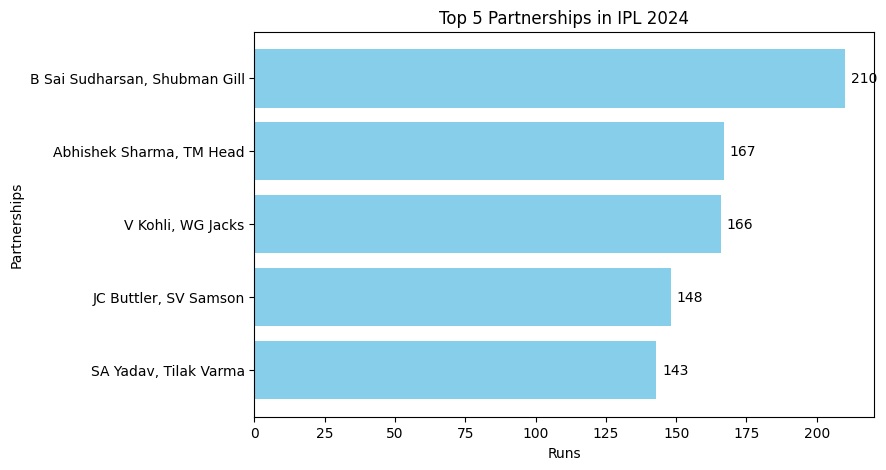

In [38]:
# List the top 5 partnerships (total runs by striker & non-striker).

partnerships_df = (
    ball_by_ball_df.groupBy("match_id",
                            least("striker", "non_striker").alias("player1"),
                            greatest("striker", "non_striker").alias("player2"))
    .agg(sum("total_runs").alias("runs").alias("runs"),
         sum(when(col("extras") > 0, 0).otherwise(1)).alias("balls"))
)

unique_team_df = ball_by_ball_df.dropDuplicates(["match_id"]).select("match_id", "bowling_team", "batting_team")

top_five_partnerships_df = (
    partnerships_df.join(unique_team_df, "match_id", "inner")
    .select(col("match_id"),
            concat_ws(", ", col("player1"), col("player2")).alias("partners"),
            col("batting_team").alias("team"),
            col("bowling_team").alias("opposition"),
            col("runs"),
            col("balls"))
    .orderBy(col("runs").desc())
    .limit(5)
)

top_five_partnerships_df.show(truncate=False)

top_five_partnerships_df = top_five_partnerships_df.toPandas()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_five_partnerships_df["partners"], top_five_partnerships_df["runs"], color="skyblue")

# Labels
ax.set_xlabel("Runs")
ax.set_ylabel("Partnerships")
ax.set_title("Top 5 Partnerships in IPL 2024")

# Show values on bars
for index, value in enumerate(top_five_partnerships_df["runs"]):
    ax.text(value + 2, index, str(value), va='center', fontsize=10)

plt.gca().invert_yaxis()  # Invert y-axis to show highest first
plt.show()

In [39]:
# Determine the most common mode of dismissal in IPL 2024.

common_dismissal_df = (
    ball_by_ball_df.filter(col("wicket_type").isNotNull())
    .groupBy("wicket_type")
    .count()
    .orderBy(col("count").desc())
)

common_dismissal_df.show(truncate=False)

+---------------------+-----+
|wicket_type          |count|
+---------------------+-----+
|caught               |644  |
|bowled               |123  |
|runout               |52   |
|lbw                  |50   |
|stumped              |13   |
|obstructing the field|1    |
+---------------------+-----+



In [40]:
# Identify which team had the best bowling performance in the death overs (16-20).

bowling_perf_df = (
    ball_by_ball_df.filter(col("over") >= 16)
    .groupBy("bowling_team")
    .agg(
        sum("total_runs").alias("total_runs_given"),
        sum(when(col("player_dismissed").isNotNull(), 1).otherwise(0)).alias("wickets")
    )
    .select(col("bowling_team").alias("team"), "total_runs_given", "wickets")
    .orderBy(col("total_runs_given").asc())
)

bowling_perf_df.show()

+----+----------------+-------+
|team|total_runs_given|wickets|
+----+----------------+-------+
|  GT|             403|     21|
| KKR|             421|     25|
|  MI|             502|     27|
| RCB|             505|     19|
| CSK|             523|     25|
| LSG|             528|     17|
|  RR|             586|     28|
| SRH|             619|     19|
|PBKS|             626|     41|
|  DC|             660|     31|
+----+----------------+-------+



In [41]:
# Identify the umpire who officiated the most matches.

most_officiated_umpire = (
    match_df.select(explode(array(col("umpire1"), col("umpire2"), col("umpire3"))).alias("umpire"))
    .filter(col("umpire").isNotNull())
    .groupBy("umpire")
    .count()
    .orderBy(col("count").desc())
    .limit(1)
)

most_officiated_umpire.show(truncate=False)

+---------------------+-----+
|umpire               |count|
+---------------------+-----+
|KN Ananthapadmanabhan|17   |
+---------------------+-----+



In [42]:
# Find out how many times a team successfully chased a target in the last over.

chased_in_last_over_df = (
    match_df.filter(col("won_by") == "wickets")
    .join(ball_by_ball_df, "match_id", "inner")
    .filter((col("over") >= 19) & (col("innings") == 2) & (col("winning_team") == col("batting_team")))
    .dropDuplicates(["match_id"])
    .select("match_id", "winning_team", "batting_team", "bowling_team", "innings1_score", "innings2_score")
    .groupBy("batting_team")
    .agg(collect_list("bowling_team").alias("oppositions"),
         count("batting_team").alias("count"))
    .orderBy(col("count").desc())
)

chased_in_last_over_df.show()

+------------+----------------+-----+
|batting_team|     oppositions|count|
+------------+----------------+-----+
|          RR|[RCB, PBKS, KKR]|    3|
|          GT| [SRH, RR, PBKS]|    3|
|         LSG|       [CSK, MI]|    2|
|        PBKS|        [DC, GT]|    2|
|         SRH|          [PBKS]|    1|
|         RCB|          [PBKS]|    1|
+------------+----------------+-----+



In [43]:
# Calculate the highest margin of victory by runs.

highest_win_margin_by_runs_df = (
    match_df.filter(col("won_by") == "runs")
    .withColumn("margin", col("margin").cast("int"))
    .orderBy(col("margin").desc())
    .select("team1", "team2", "margin", "winning_team")
    .limit(1)
)

highest_win_margin_by_runs_df.show()

+-----+-----+------+------------+
|team1|team2|margin|winning_team|
+-----+-----+------+------------+
|  KKR|   DC|   106|         KKR|
+-----+-----+------+------------+



In [44]:
# Calculate the highest margin of victory by wickets.

highest_win_margin_by_wickets_df = (
    match_df.filter(col("won_by") == "wickets")
    .withColumn("margin", col("margin").cast("int"))
    .orderBy(col("margin").desc())
    .select("team1", "team2", "margin", "winning_team")
    .limit(1)
)

highest_win_margin_by_wickets_df.show()

+-----+-----+------+------------+
|team1|team2|margin|winning_team|
+-----+-----+------+------------+
|  LSG|  SRH|    10|         SRH|
+-----+-----+------+------------+



In [45]:
# Analyze whether toss-winning teams had a higher probability of winning the match.

total_matches = match_df.filter(col("winning_team").isNotNull()).count()

toss_win_match_win_df = match_df.filter(col("toss_winner") == col("winning_team"))
toss_win_match_count = toss_win_match_win_df.count()

probability = (toss_win_match_count / total_matches) * 100

print(f"Probability of toss-winning team winning the match: {probability:.2f}%")

Probability of toss-winning team winning the match: 43.66%


In [46]:
# Use a window function to find the top run scorers in each match.

run_scored_df = ball_by_ball_df.groupBy("match_id", "striker").agg(sum("runs_of_bat").alias("individual_score"))

rank_window = Window.partitionBy("match_id").orderBy(col("individual_score").desc())

top_run_scorer_df = run_scored_df.withColumn("rank", dense_rank().over(rank_window)).filter(col("rank") == 1)

top_run_scorer_df.show()

+--------+---------------+----------------+----+
|match_id|        striker|individual_score|rank|
+--------+---------------+----------------+----+
|  202401|     Anuj Rawat|              48|   1|
|  202402|      SM Curran|              63|   1|
|  202403|     AD Russell|              64|   1|
|  202404|      SV Samson|              82|   1|
|  202405|       D Brevis|              46|   1|
|  202406|        V Kohli|              77|   1|
|  202407|         S Dube|              51|   1|
|  202408|      H Klaasen|              80|   1|
|  202409|        R Parag|              84|   1|
|  202410|        V Kohli|              83|   1|
|  202411|       S Dhawan|              70|   1|
|  202412|B Sai Sudharsan|              45|   1|
|  202413|      DA Warner|              52|   1|
|  202414|        R Parag|              54|   1|
|  202415|      Q de Kock|              81|   1|
|  202416|      SP Narine|              85|   1|
|  202417|   Shubman Gill|              89|   1|
|  202418|     AK Ma

In [47]:
# Best team score

team_score = (
    ball_by_ball_df.groupBy("match_id", "batting_team")
    .agg(sum("total_runs").alias("score"),
         count(col("player_dismissed")).alias("wickets_lost"))
)

rank_window = Window.partitionBy("match_id").orderBy(col("score").desc())

best_team_score = (
    team_score.withColumn("rank", dense_rank().over(rank_window))
    .filter(col("rank") == 1)
    .orderBy(col("score").desc())
    .limit(1)
)

best_team_score.show()

+--------+------------+-----+------------+----+
|match_id|batting_team|score|wickets_lost|rank|
+--------+------------+-----+------------+----+
|  202430|         SRH|  287|           3|   1|
+--------+------------+-----+------------+----+



In [48]:
spark.stop()